<font color = blue><font size = 6> 실험설명 </font></font><br>
Seasonality 한주기를 임의 설정한후 moving average를 주기마다 겹치지 않게 해보겠다(Stride를 조정하겠다는 의미)<br>
여기서는 Linear layer하나에 한개의 trend가 들어가게 된다<br>
이것을 하는 이유는 DLinear에서 Decompose를 할때 moving average 자체에 어느정도의 seasonallity가 포함돼 있는거 같기 때문에 이를 더 엄격하게 구분하기 위해서 이다 
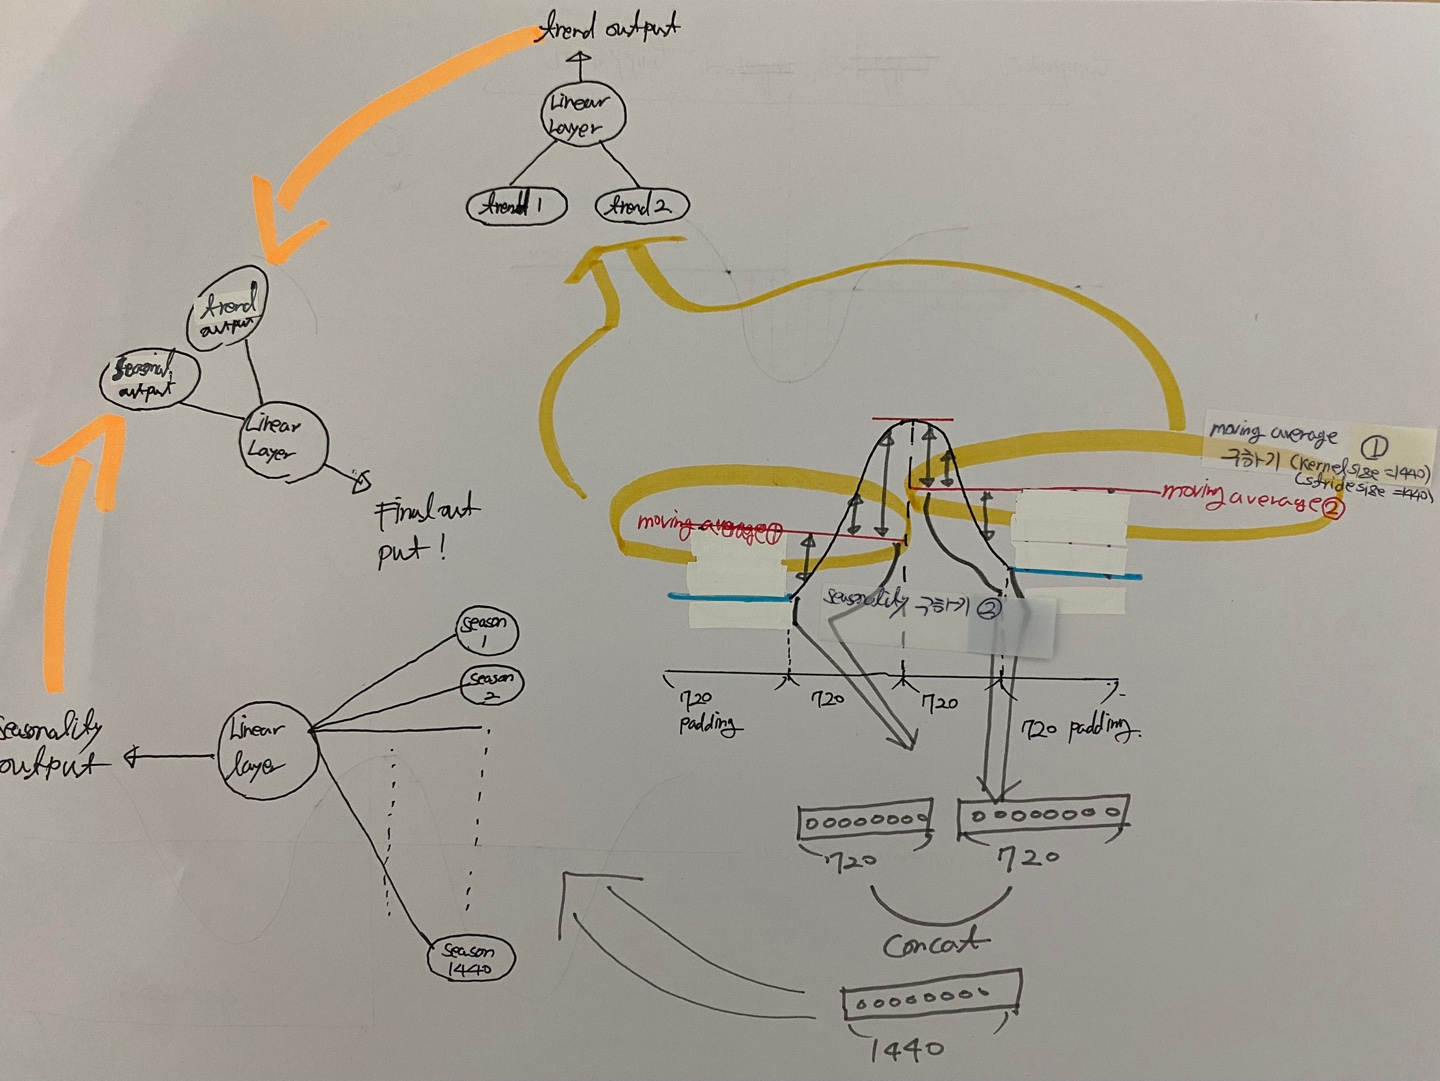

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,MAPE,RMSE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/4.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


<AxesSubplot: >

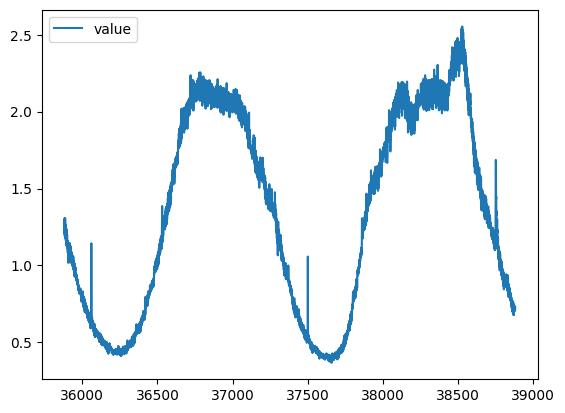

In [4]:
data[-3000:].plot() # 1일의 계절성이 있는것으로 판단된다

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel2/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))
        
        
        return x

[1,1,1] Size에서 [1,2,1] Size를 빼면 앞에꺼 원소 한개를 뒤에 원소 2개에 대응한다

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        moving_mean = moving_mean.permute(0,2,1)
        
        x = x.permute(0,2,1)
        
        res = torch.cat([x[:,:720,:] - moving_mean[:,0:1,:],x[:,720:,:]-moving_mean[:,1:2,:]],dim=1)
        
        # Classical ma중에서 additive model
        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 1440
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len//self.stride,self.pred_len)) # 이렇게 설정하면 현재 상황에선 Layer당 Unit이 1개
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(2,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device)
        
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_579733/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 98.55484341930227 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 63.148245866579266 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 43.708305494609284 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 26.91710180641092 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 16.590272392097273 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 8.090087134195 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 5.512760118063953 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 6.007613015431932 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 6.074436102824951 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 6.164466843597198 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 6.091452358965898 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 6.108942513152608 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 6.060690313566759 %
Adjusting le

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 1.923567798001386 %
SMAPE 0.26681759389975923 %
SMAPE 0.18619616821706586 %
SMAPE 0.4082999751508396 %
SMAPE 1.3497886591253518 %
SMAPE 1.7724733133200061 %
SMAPE 1.3670989630199983 %
SMAPE 0.7618078890518518 %
SMAPE 0.29964815961852764 %
SMAPE 0.379843611624608 %
SMAPE 0.9968331186992146 %
SMAPE 1.5832616493316891 %
SMAPE 1.6459172605118513 %
SMAPE 2.0283543937912327 %
SMAPE 2.0336058579632663 %
SMAPE 1.5464353458701225 %
SMAPE 0.6955040922935041 %
SMAPE 0.9938420699627385 %
SMAPE 0.7349561639352942 %
SMAPE 0.16058581788661286 %
SMAPE 0.07135295570833478 %
SMAPE 0.05187035888582159 %
SMAPE 0.8512764445895301 %
SMAPE 1.8429043407595598 %
SMAPE 2.06902095957048 %
SMAPE 1.7694244822841938 %
SMAPE 3.09539168565243 %
SMAPE 3.584378191164433 %
SMAPE 2.75368550150597 %
SMAPE 1.812532853027733 %
SMAPE 3.3592708369542383 %
SMAPE 3.06972301610665 %
SMAPE 4.01236152893398 %
SMAPE 3.2281059156873653 %
SMAPE 3.1413180971649126 %
SMAPE 2.9603613734270766 %
SMAPE 2.9636603226172156 %
SMAPE 2.0

SMAPE 1.4055123579128121 %
SMAPE 2.5356635614516563 %
SMAPE 1.3213252143849559 %
SMAPE 0.4261509755192492 %
SMAPE 0.7032658821527065 %
SMAPE 1.910576638912971 %
SMAPE 1.3274520246641117 %
SMAPE 1.0372891990396056 %
SMAPE 0.7605395381233393 %
SMAPE 1.2550958378596988 %
SMAPE 1.0624937398667953 %
SMAPE 1.0626938763307407 %
SMAPE 1.046335115457623 %
SMAPE 1.8310537333163666 %
SMAPE 3.8723901482153456 %
SMAPE 6.533260037744185 %
SMAPE 3.3141611602404737 %
SMAPE 1.8080090807970919 %
SMAPE 1.437410584814188 %
SMAPE 3.7176138149252442 %
SMAPE 3.228204966895646 %
SMAPE 1.7754824176954571 %
SMAPE 1.6270425401562534 %
SMAPE 0.9695446131354402 %
SMAPE 0.6108384441313319 %
SMAPE 0.39564578754652757 %
SMAPE 0.38624930866581053 %
SMAPE 0.4840488910267595 %
SMAPE 0.39782283230124454 %
SMAPE 1.4027707282366464 %
SMAPE 2.1102610316156643 %
SMAPE 0.056982360999882076 %
SMAPE 0.5880784222215425 %
SMAPE 0.4040345445264393 %
SMAPE 0.8301404613266641 %
SMAPE 0.6748324490035884 %
SMAPE 0.4756528666230224 %
S

SMAPE 0.6483597201977318 %
SMAPE 0.5153879810150102 %
SMAPE 0.4328551574710673 %
SMAPE 0.42422993926720665 %
SMAPE 0.34593250200441616 %
SMAPE 0.05081414595952083 %
SMAPE 0.12463976690179378 %
SMAPE 0.3508830432610921 %
SMAPE 0.6892074253155442 %
SMAPE 0.6802533988598043 %
SMAPE 0.7801999212820192 %
SMAPE 2.1736699082848645 %
SMAPE 1.5668977785630887 %
SMAPE 0.7677501382440823 %
SMAPE 0.9018628625162818 %
SMAPE 0.8487219315129549 %
SMAPE 0.5438009324589075 %
SMAPE 0.09015184545160082 %
SMAPE 0.586761405899324 %
SMAPE 0.9171641752500364 %
SMAPE 0.21595090894089708 %
SMAPE 0.19333115244080545 %
SMAPE 0.9979954191985598 %
SMAPE 0.9279614458228025 %
SMAPE 0.3071576336419639 %
SMAPE 0.20809411575464765 %
SMAPE 0.0076935599762464335 %
SMAPE 0.17715022742305564 %
SMAPE 0.03576400847032346 %
SMAPE 0.30444098165276046 %
SMAPE 0.3739455318882392 %
SMAPE 0.5236549107721657 %
SMAPE 1.6073081685444777 %
SMAPE 2.443088197727775 %
SMAPE 1.898672642848169 %
SMAPE 0.8775063868051802 %
SMAPE 0.475936600

SMAPE 0.5225906257796851 %
SMAPE 1.4789437941944925 %
SMAPE 1.9085746409873534 %
SMAPE 0.3793029093503719 %
SMAPE 0.016764327328473883 %
SMAPE 0.03462399265663407 %
SMAPE 0.5312865458236047 %
SMAPE 0.6097218509830782 %
SMAPE 0.21617722787726734 %
SMAPE 0.05207108567014984 %
SMAPE 0.09582464241438515 %
SMAPE 0.07084262391992979 %
SMAPE 0.5252260314185833 %
SMAPE 0.008611653369172245 %
SMAPE 0.09052669452557893 %
SMAPE 2.8728154350346813 %
SMAPE 4.955851139500737 %
SMAPE 2.275916752667399 %
SMAPE 4.713516218587756 %
SMAPE 4.943863362073898 %
SMAPE 4.904447583481669 %
SMAPE 3.8016676986590032 %
SMAPE 6.073142610490322 %
SMAPE 3.5661650421097875 %
SMAPE 4.769763646647334 %
SMAPE 3.7304592570289974 %
SMAPE 6.010114213451743 %
SMAPE 4.151677385903895 %
SMAPE 6.465300070121885 %
SMAPE 3.0327384557022015 %
SMAPE 4.403568581445143 %
SMAPE 5.606963210739195 %
SMAPE 5.094265419524163 %
SMAPE 4.580417492194101 %
SMAPE 1.6449669979774626 %
SMAPE 0.9570895416422899 %
SMAPE 0.33077712922931823 %
SMAP

SMAPE 0.09876064366289938 %
SMAPE 0.023466579168221813 %
SMAPE 0.04541583911031921 %
SMAPE 0.3261103603972515 %
SMAPE 0.7984400053323952 %
SMAPE 1.4681248483429954 %
SMAPE 1.2838459088998206 %
SMAPE 0.1719971328329848 %
SMAPE 0.04450241812992317 %
SMAPE 0.6102245490598364 %
SMAPE 0.10678386930055694 %
SMAPE 0.04061347462629783 %
SMAPE 0.019806957370917644 %
SMAPE 0.7165696310476051 %
SMAPE 0.2620197611013282 %
SMAPE 0.1597271320447362 %
SMAPE 0.27301503578655684 %
SMAPE 1.3009579794088495 %
SMAPE 0.3538024052520541 %
SMAPE 0.3615465574657719 %
SMAPE 0.9001788668956577 %
SMAPE 0.43834653486737807 %
SMAPE 0.4435422151837827 %
SMAPE 0.2967815565514016 %
SMAPE 0.40985676615468947 %
SMAPE 0.6564442621211128 %
SMAPE 0.1430174865463414 %
SMAPE 0.31687652472101036 %
SMAPE 0.4050557005889459 %
SMAPE 0.2385023863303104 %
SMAPE 0.08596594528899004 %
SMAPE 0.18625600034010859 %
SMAPE 0.031133971678514172 %
SMAPE 0.6348295878433419 %
SMAPE 0.24708746347278066 %
SMAPE 0.5677995038167865 %
SMAPE 0.50

SMAPE 3.4223548404261237 %
SMAPE 5.270505531691015 %
SMAPE 4.050608692559763 %
SMAPE 8.403331086039543 %
SMAPE 1.7924486298816191 %
SMAPE 5.307125189239741 %
SMAPE 3.1809863520393264 %
SMAPE 3.192122338892659 %
SMAPE 3.1198894159242627 %
SMAPE 3.295296313488507 %
SMAPE 2.4324124683625996 %
SMAPE 5.399472714401782 %
SMAPE 4.437807613052428 %
SMAPE 8.61102532222867 %
SMAPE 2.660157359976438 %
SMAPE 5.7164921928197145 %
SMAPE 5.835489256307483 %
SMAPE 7.489516250789166 %
SMAPE 4.1592085445299745 %
SMAPE 8.587905883789062 %
SMAPE 0.9623152112053504 %
SMAPE 3.8813168341366695 %
SMAPE 6.161931194365025 %
SMAPE 6.48874581232667 %
SMAPE 4.310949572827667 %
SMAPE 8.021136689931154 %
SMAPE 2.232665024937887 %
SMAPE 7.328792538493873 %
SMAPE 4.3466336122801295 %
SMAPE 7.173375468701123 %
SMAPE 2.8798890692960413 %
SMAPE 5.6628025121754035 %
SMAPE 5.185621109092608 %
SMAPE 8.813892912119627 %
SMAPE 3.5409441301890188 %
SMAPE 9.499769827350974 %
SMAPE 8.012827280908823 %
SMAPE 5.622725503999391 %
S

SMAPE 1.5284887464640633 %
SMAPE 1.4503218674890377 %
SMAPE 0.14163678260274537 %
SMAPE 2.5339502669098692 %
SMAPE 1.4175557252456201 %
SMAPE 0.08972136424142718 %
SMAPE 0.7321539301628945 %
SMAPE 0.4751961259144082 %
SMAPE 0.02211474917258016 %
SMAPE 0.32437407845736743 %
SMAPE 0.9700612169071974 %
SMAPE 0.43085663075044073 %
SMAPE 0.898073630275576 %
SMAPE 2.3850332792062545 %
SMAPE 1.180532077832595 %
SMAPE 1.0429352514138372 %
SMAPE 1.0648270257042896 %
SMAPE 1.0047525926474918 %
SMAPE 1.8193452974155662 %
SMAPE 2.2281076208141712 %
SMAPE 1.5409770830933667 %
SMAPE 2.269111610505888 %
SMAPE 1.718057085699911 %
SMAPE 3.4331003172701458 %
SMAPE 1.4452971584396437 %
SMAPE 0.7760886024152569 %
SMAPE 1.355980936488777 %
SMAPE 0.7093590617409973 %
SMAPE 0.40046036142757657 %
SMAPE 1.6851617046499998 %
SMAPE 0.6111460829661155 %
SMAPE 2.648159416505223 %
SMAPE 1.6399103178009682 %
SMAPE 14.385499589145184 %
SMAPE 0.13703967321362143 %
SMAPE 1.026861882131925 %
SMAPE 3.587201502033395 %
SM

SMAPE 0.030117298782897702 %
SMAPE 1.8489272972110484 %
SMAPE 1.2286185207221934 %
SMAPE 1.0865878935783257 %
SMAPE 0.5320753061030246 %
SMAPE 0.05217410868067419 %
SMAPE 0.011170667607075302 %
SMAPE 0.10245500053952128 %
SMAPE 0.011031742864417993 %
SMAPE 0.35632837817352225 %
SMAPE 0.016565996696876084 %
SMAPE 0.1826587238438151 %
SMAPE 0.13498198097477143 %
SMAPE 0.26523116104317523 %
SMAPE 0.604085031361592 %
SMAPE 0.12177467551538258 %
SMAPE 0.0270321831592355 %
SMAPE 0.21136363506047928 %
SMAPE 0.02541087130913411 %
SMAPE 0.11084893537736207 %
SMAPE 0.3162012923362454 %
SMAPE 1.4737151747585813 %
SMAPE 1.2645701390392787 %
SMAPE 0.5881633633871388 %
SMAPE 0.3812644825825373 %
SMAPE 0.08395433903251615 %
SMAPE 0.014163365615956991 %
SMAPE 0.1018046278887823 %
SMAPE 0.3915770912840344 %
SMAPE 0.19937993198504955 %
SMAPE 0.36186720084310764 %
SMAPE 1.3524507314505172 %
SMAPE 0.8001820270237658 %
SMAPE 0.1284478858960938 %
SMAPE 0.04089011209845239 %
SMAPE 0.8278694739611865 %
SMAPE 

SMAPE 1.677829049534921 %
SMAPE 0.572385069302527 %
SMAPE 0.7901580649881907 %
SMAPE 0.3694844548681431 %
SMAPE 0.5708992427997259 %
SMAPE 0.22061334600584817 %
SMAPE 0.2363740467149782 %
SMAPE 0.0397548518790245 %
SMAPE 0.573652611498801 %
SMAPE 0.31306078910756696 %
SMAPE 0.7772132943773613 %
SMAPE 0.5395975908522814 %
SMAPE 0.17528769002456102 %
SMAPE 0.6358981667214607 %
SMAPE 1.5331361198877858 %
SMAPE 0.6435955957754231 %
SMAPE 0.6982861422575297 %
SMAPE 0.4549562685670025 %
SMAPE 0.3926523216656221 %
SMAPE 0.29547103623372095 %
SMAPE 0.6554252885262031 %
SMAPE 0.09189017256130683 %
SMAPE 0.26072317836019465 %
SMAPE 0.7162642616790436 %
SMAPE 0.22439394509638078 %
SMAPE 0.5344274742988091 %
SMAPE 0.14756111239148595 %
SMAPE 0.4056290502416289 %
SMAPE 0.6176838372426801 %
SMAPE 0.9819095186840059 %
SMAPE 1.4352194380626315 %
SMAPE 0.08793881957080885 %
SMAPE 0.725905318417972 %
SMAPE 0.5265575034529206 %
SMAPE 2.1206964399534627 %
SMAPE 0.29719162914125263 %
SMAPE 0.13373326292037

SMAPE 0.11396601614512747 %
SMAPE 0.18684245914141684 %
SMAPE 0.02342981904757835 %
SMAPE 0.03814274906471837 %
SMAPE 0.023673528596191318 %
SMAPE 0.13237198685044405 %
SMAPE 0.07416723188725882 %
SMAPE 0.38667417896358813 %
SMAPE 0.11970321287117257 %
SMAPE 0.030112032213537532 %
SMAPE 0.057343541930094936 %
SMAPE 0.59124561399085 %
SMAPE 0.06294957984300709 %
SMAPE 0.23487391464186658 %
SMAPE 0.38075355549244705 %
SMAPE 0.12044785119360313 %
SMAPE 0.050244149996615306 %
SMAPE 1.63510880464537 %
SMAPE 0.1634425480515347 %
SMAPE 0.029644488506164635 %
SMAPE 0.7925122334199841 %
SMAPE 0.44464038196315414 %
SMAPE 0.0196850587602313 %
SMAPE 0.01959144244528943 %
SMAPE 0.3389337052777819 %
SMAPE 0.319076378403679 %
SMAPE 0.030622854385228496 %
SMAPE 0.2333445502338236 %
SMAPE 0.4699136739784535 %
SMAPE 0.1939423517217591 %
SMAPE 0.46976987188190833 %
SMAPE 1.1477301043913712 %
SMAPE 0.4230922620199635 %
SMAPE 0.0576324468530629 %
SMAPE 0.07258065862106378 %
SMAPE 13.979561209678652 %
SMAPE

SMAPE 0.6993159254361672 %
SMAPE 1.1582818647802924 %
SMAPE 0.36511134971442516 %
SMAPE 0.5234842610261694 %
SMAPE 0.6252241043948743 %
SMAPE 0.4121275017541848 %
SMAPE 0.8279393234333838 %
SMAPE 1.1001447878952604 %
SMAPE 0.7020104253915633 %
SMAPE 0.6166120981397398 %
SMAPE 0.44303865796973696 %
SMAPE 0.49034915089214337 %
SMAPE 1.1485405928603 %
SMAPE 0.33172346451613066 %
SMAPE 0.2419298344557319 %
SMAPE 0.9811149532106356 %
SMAPE 0.8099388205164361 %
SMAPE 1.052735345027486 %
SMAPE 1.7443956524239184 %
SMAPE 0.6138420965269233 %
SMAPE 0.4003293471745906 %
SMAPE 0.7825330395717175 %
SMAPE 1.0267290761621553 %
SMAPE 1.1076299488267978 %
SMAPE 1.106457522353594 %
SMAPE 1.2481192394807294 %
SMAPE 0.9485545648421976 %
SMAPE 0.42004406925553894 %
SMAPE 1.218356883463457 %
SMAPE 1.329670631159388 %
SMAPE 0.4241686298091736 %
SMAPE 1.6925850242843126 %
SMAPE 0.9177666501400381 %
SMAPE 0.9291820461171483 %
SMAPE 0.31648817780569516 %
SMAPE 0.8434341072797906 %
SMAPE 1.3534567214155686 %
SM

SMAPE 0.19260300552559784 %
SMAPE 1.544248511803744 %
SMAPE 5.8766384068876505 %
SMAPE 1.3504080506263563 %
SMAPE 1.4435238406513236 %
SMAPE 2.6276289165580238 %
SMAPE 2.3190507389008417 %
SMAPE 1.0378598130464525 %
SMAPE 1.2360369909056317 %
SMAPE 1.461067721262225 %
SMAPE 0.7483884936027607 %
SMAPE 2.4721516379213426 %
SMAPE 0.8641041795199271 %
SMAPE 2.057234770566538 %
SMAPE 2.9410400275228312 %
SMAPE 0.43977660691211895 %
SMAPE 0.6141084649116237 %
SMAPE 1.7010787763647384 %
SMAPE 0.8135752299967862 %
SMAPE 0.8266659559069467 %
SMAPE 0.11045596274993841 %
SMAPE 0.811194189373964 %
SMAPE 0.04505264414001431 %
SMAPE 0.046319316338667704 %
SMAPE 0.6161633558572248 %
SMAPE 0.5526141322911826 %
SMAPE 0.13537783288757055 %
SMAPE 0.6498432109519854 %
SMAPE 0.16513675457170507 %
SMAPE 1.1101404367236682 %
SMAPE 1.2230559095496574 %
SMAPE 0.17809530129579798 %
SMAPE 1.4205810204744012 %
SMAPE 0.2494794172166621 %
SMAPE 1.0727374862569832 %
SMAPE 0.8320191311577219 %
SMAPE 0.572837698526200

SMAPE 0.4636936096276258 %
SMAPE 0.9612020987035521 %
SMAPE 0.6956448645569253 %
SMAPE 0.03550688071931063 %
SMAPE 0.04974325523221523 %
SMAPE 0.41835514771992166 %
SMAPE 0.08211228024299544 %
SMAPE 0.8751494534849371 %
SMAPE 0.02761724232505003 %
SMAPE 0.056985183841788974 %
SMAPE 0.08115869158427813 %
SMAPE 0.497630030786695 %
SMAPE 0.09446606738492846 %
SMAPE 0.03264768527674278 %
SMAPE 0.20349551718459227 %
SMAPE 0.36146493991873285 %
SMAPE 0.322957109649451 %
SMAPE 0.061466820177088266 %
SMAPE 0.49537792597897123 %
SMAPE 0.023542042037661304 %
SMAPE 0.1742520599736963 %
SMAPE 0.3148053783297655 %
SMAPE 0.38258722298905923 %
SMAPE 0.016828279792207468 %
SMAPE 0.13029166874230214 %
SMAPE 0.0726343587066367 %
SMAPE 0.037542363364991616 %
SMAPE 0.3202554284398502 %
SMAPE 0.014723898898978406 %
SMAPE 0.02675983796780201 %
SMAPE 0.18097488773526038 %
SMAPE 0.06930026706004355 %
SMAPE 0.6556126904676489 %
SMAPE 0.18612855506739834 %
SMAPE 0.1708640356791875 %
SMAPE 0.3727883883116192 %
S

SMAPE 0.6212429489023634 %
SMAPE 0.24257632216324512 %
SMAPE 0.24647935920097552 %
SMAPE 0.4478429055138804 %
SMAPE 0.052092009092802975 %
SMAPE 0.006904787035992399 %
SMAPE 0.10693362086522029 %
SMAPE 0.15693115960152682 %
SMAPE 0.17025901137367327 %
SMAPE 0.07217402887317803 %
SMAPE 0.08494914255288677 %
SMAPE 0.05154596811121337 %
SMAPE 0.04882098692519321 %
SMAPE 0.4935633952761691 %
SMAPE 0.11990795908423024 %
SMAPE 0.4147990718665824 %
SMAPE 0.02063021294588907 %
SMAPE 1.0980613197189086 %
SMAPE 0.4273105335068976 %
SMAPE 0.09915184517478792 %
SMAPE 0.020447537695190476 %
SMAPE 0.08164960786143638 %
SMAPE 0.3108653948813185 %
SMAPE 0.041472386626310254 %
SMAPE 0.18609566521581655 %
SMAPE 0.1724274578106133 %
SMAPE 0.18585785639152164 %
SMAPE 0.22146932290172572 %
SMAPE 0.041920335199392866 %
SMAPE 0.06553603191218826 %
SMAPE 0.40254832110349525 %
SMAPE 0.12000987729288681 %
SMAPE 0.0868474889070967 %
SMAPE 0.04661705666615035 %
SMAPE 0.981860969188574 %
SMAPE 0.4771508339842967 %

SMAPE 0.3433421311110578 %
SMAPE 0.053974328152435185 %
SMAPE 0.15151570665329928 %
SMAPE 0.11920900139523383 %
SMAPE 0.21211440119122926 %
SMAPE 0.603661164343066 %
SMAPE 0.13892996525555645 %
SMAPE 1.4197784025309375 %
SMAPE 0.8206523067547095 %
SMAPE 0.31792126510663365 %
SMAPE 0.25384234177022336 %
SMAPE 0.7322613279329744 %
SMAPE 0.2783409786388802 %
SMAPE 0.31215658097016785 %
SMAPE 0.7530344248725669 %
SMAPE 0.6561853142512746 %
SMAPE 0.6101229380606128 %
SMAPE 0.1994327010725101 %
SMAPE 1.6161628236604881 %
SMAPE 0.8495470016405305 %
SMAPE 0.5142741683403074 %
SMAPE 0.962808538128229 %
SMAPE 0.5510071907301608 %
SMAPE 0.398876235023181 %
SMAPE 0.45866083914870615 %
SMAPE 0.5200287879233656 %
SMAPE 1.282787951653745 %
SMAPE 0.9581065368561212 %
SMAPE 0.7692392860597721 %
SMAPE 0.9478182108084638 %
SMAPE 0.5137045259342585 %
SMAPE 0.6577282941580052 %
SMAPE 0.7339992547690599 %
SMAPE 1.461910446651018 %
SMAPE 0.29656343479550173 %
SMAPE 0.6244051310736722 %
SMAPE 0.68916628933584

SMAPE 1.5781975996833353 %
SMAPE 0.46974798601877416 %
SMAPE 1.0833760977038764 %
SMAPE 0.2426847787573934 %
SMAPE 1.135052570294647 %
SMAPE 0.5497892378007236 %
SMAPE 0.5999518119815548 %
SMAPE 0.13766484745246999 %
SMAPE 0.33001880983920273 %
SMAPE 0.24783836587550923 %
SMAPE 0.5574290291733632 %
SMAPE 0.2729783395770937 %
SMAPE 0.38606003989480087 %
SMAPE 0.2522252466063719 %
SMAPE 0.8606531735531463 %
SMAPE 0.12202761670596374 %
SMAPE 0.7232477660036238 %
SMAPE 0.16854165585391456 %
SMAPE 0.4080227440535964 %
SMAPE 0.27634900543898766 %
SMAPE 0.328018810312642 %
SMAPE 0.4951435446455435 %
SMAPE 0.37031568650309055 %
SMAPE 0.5242007539973201 %
SMAPE 0.2335774260893686 %
SMAPE 0.2698880636235117 %
SMAPE 0.2773664006526815 %
SMAPE 0.08696938817411137 %
SMAPE 0.18216714309892268 %
SMAPE 0.24641701381915485 %
SMAPE 0.06993219026594488 %
SMAPE 0.058529169522444136 %
SMAPE 1.175294531014515 %
SMAPE 0.9107837398041739 %
SMAPE 0.273366430661099 %
SMAPE 0.4858580431980499 %
SMAPE 0.579419692

SMAPE 0.009587031109134614 %
SMAPE 0.142642536627136 %
SMAPE 0.38009360658179503 %
SMAPE 0.17065159610137925 %
SMAPE 0.3367617260460065 %
SMAPE 0.5618057821939146 %
SMAPE 0.028633202144192182 %
SMAPE 0.15653938709147042 %
SMAPE 0.6422074631238104 %
SMAPE 0.04055142670625855 %
SMAPE 0.08358084959195367 %
SMAPE 0.15844083706065248 %
SMAPE 0.7970956424924226 %
SMAPE 0.03594545940086391 %
SMAPE 0.9866279887210111 %
SMAPE 0.19609506177130243 %
SMAPE 0.38196444892582804 %
SMAPE 0.5509030648627231 %
SMAPE 0.15655928162595956 %
SMAPE 0.03737596135378851 %
SMAPE 0.39640529017447074 %
SMAPE 0.05857145990148637 %
SMAPE 0.5118319254761445 %
SMAPE 0.7577347920523607 %
SMAPE 0.1015898228529295 %
SMAPE 0.16249191399447227 %
SMAPE 0.6374035562912468 %
SMAPE 0.46295388640965024 %
SMAPE 0.0783971412558202 %
SMAPE 0.019896401492246696 %
SMAPE 0.7599480827502703 %
SMAPE 0.01176364228501825 %
SMAPE 0.02192113646060534 %
SMAPE 0.11843049005142348 %
SMAPE 0.08074913100995218 %
SMAPE 1.8057271451179986 %
SMAP

SMAPE 0.10705386594006681 %
SMAPE 0.09554298780204817 %
SMAPE 0.07131557406484035 %
SMAPE 0.01991013902818395 %
SMAPE 0.07084443159237708 %
SMAPE 0.194029236048209 %
SMAPE 0.3554825951734415 %
SMAPE 0.01908216176229871 %
SMAPE 2.909147893456975 %
SMAPE 0.11413316564517118 %
SMAPE 0.1406700649295658 %
SMAPE 0.2970144583639467 %
SMAPE 0.04238725798552423 %
SMAPE 0.13887930855287323 %
SMAPE 0.0665874201833958 %
SMAPE 0.015067179885591031 %
SMAPE 0.05864472069208659 %
SMAPE 0.11053492837720569 %
SMAPE 0.28717806650524835 %
SMAPE 0.012190121196056225 %
SMAPE 0.2657779062647023 %
SMAPE 0.17628988568117165 %
SMAPE 0.2554468235346121 %
SMAPE 0.28072472335691145 %
SMAPE 0.023981501838534314 %
SMAPE 0.026379999117921216 %
SMAPE 0.06126740399759001 %
SMAPE 0.027613878828105957 %
SMAPE 1.132837765102522 %
SMAPE 0.2997677014955116 %
SMAPE 0.15123353145332885 %
SMAPE 0.05154301394031791 %
SMAPE 0.022025252904029458 %
SMAPE 0.18769642631286843 %
SMAPE 0.1233779441504339 %
SMAPE 0.13261306130931416 %


SMAPE 0.010717674594332038 %
SMAPE 0.3823758786529652 %
SMAPE 0.06523625993168025 %
SMAPE 0.4493416130380865 %
SMAPE 0.7887933541278471 %
SMAPE 0.018155808105234428 %
SMAPE 0.4967019314708523 %
SMAPE 0.03718557541952805 %
SMAPE 0.01172954295600448 %
SMAPE 0.2191304746966125 %
SMAPE 0.429700706900121 %
SMAPE 0.14536075953174077 %
SMAPE 0.03623903555102714 %
SMAPE 0.27472187744388066 %
SMAPE 0.40177429712230145 %
SMAPE 0.2580605469374859 %
SMAPE 1.2772983395768733 %
SMAPE 0.06623996634147744 %
SMAPE 2.1591493699816056 %
SMAPE 0.31646195435507707 %
SMAPE 1.3304990348606225 %
SMAPE 0.25482485472775807 %
SMAPE 1.3138998057111166 %
SMAPE 0.4991489605063179 %
SMAPE 0.43625429463077126 %
SMAPE 2.043679807909939 %
SMAPE 0.023648478423638153 %
SMAPE 1.1608465429235366 %
SMAPE 0.3378648086200684 %
SMAPE 0.20646197002793087 %
SMAPE 0.1617813343304988 %
SMAPE 0.5028235009482387 %
SMAPE 0.040421158108301825 %
SMAPE 0.018718861077843485 %
SMAPE 1.3156156263839875 %
SMAPE 0.3731394828801058 %
SMAPE 0.

SMAPE 0.2089862132552298 %
SMAPE 0.4439940896096459 %
SMAPE 0.27863278359291144 %
SMAPE 0.35835804670750804 %
SMAPE 0.16166965089382757 %
SMAPE 0.5670035031002953 %
SMAPE 0.37361582892572187 %
SMAPE 0.22984298025585304 %
SMAPE 0.04796278635981821 %
SMAPE 0.4824298536077549 %
SMAPE 0.2998999911277451 %
SMAPE 0.225882419915024 %
SMAPE 0.07066356333689328 %
SMAPE 0.10242811655245987 %
SMAPE 0.10809596296894597 %
SMAPE 0.8352697711502514 %
SMAPE 0.16453460383741003 %
SMAPE 0.5537235083011183 %
SMAPE 0.0525096740002482 %
SMAPE 0.32962454583821454 %
SMAPE 0.05369128644406373 %
SMAPE 0.3842510963525001 %
SMAPE 0.6689020772532785 %
SMAPE 0.3225791951044812 %
SMAPE 0.1164748515257088 %
SMAPE 0.40912066253076773 %
SMAPE 0.41235465212527345 %
SMAPE 0.08794346678496368 %
SMAPE 0.04602440061307789 %
SMAPE 0.6219997011162377 %
SMAPE 0.1545704250493145 %
SMAPE 0.20277366444133804 %
SMAPE 0.638601648130134 %
SMAPE 0.2678486480986919 %
SMAPE 0.2197405418010021 %
SMAPE 0.07836174276167185 %
SMAPE 0.0892

SMAPE 0.28222791203370434 %
SMAPE 0.0663635631381112 %
SMAPE 0.7069226905226742 %
SMAPE 0.5411866384019959 %
SMAPE 1.0089676646175576 %
SMAPE 0.31273897944993223 %
SMAPE 0.7504440378688741 %
SMAPE 0.5451653095515212 %
SMAPE 0.8909491934391554 %
SMAPE 0.9053437721422596 %
SMAPE 0.6860947695467985 %
SMAPE 0.12306137017003493 %
SMAPE 1.114225126184465 %
SMAPE 0.7411487507197307 %
SMAPE 1.821249155692385 %
SMAPE 0.40704611267210566 %
SMAPE 0.6942072201054543 %
SMAPE 0.7372976683477646 %
SMAPE 0.9735000103395919 %
SMAPE 1.3422341228397272 %
SMAPE 1.2568717923822987 %
SMAPE 0.25825506725595915 %
SMAPE 1.5013756578550783 %
SMAPE 2.1434112202960023 %
SMAPE 2.0190048260919866 %
SMAPE 1.9008245601617089 %
SMAPE 2.4517963444832276 %
SMAPE 1.023768074108375 %
SMAPE 1.9050178750776465 %
SMAPE 1.1777354539901523 %
SMAPE 1.057244904786785 %
SMAPE 0.8128306830440125 %
SMAPE 0.6517049015908469 %
SMAPE 0.7192669366704649 %
SMAPE 1.6541492975429717 %
SMAPE 0.7996494319704651 %
SMAPE 0.7985485147144119 %


SMAPE 0.5128859774831653 %
SMAPE 0.01248543127918822 %
SMAPE 0.016618855331898885 %
SMAPE 0.16964207490946137 %
SMAPE 0.06403996678591284 %
SMAPE 1.029531043838233 %
SMAPE 0.14075621278789185 %
SMAPE 0.1693290335515485 %
SMAPE 0.13994742088516432 %
SMAPE 0.5019259760629211 %
SMAPE 0.9725877762721211 %
SMAPE 0.40944979901792067 %
SMAPE 0.030501610391183934 %
SMAPE 0.09382551813109785 %
SMAPE 0.28709095058547973 %
SMAPE 0.3161632209363745 %
SMAPE 0.12671942419615334 %
SMAPE 1.6268301784730284 %
SMAPE 0.3718970619938773 %
SMAPE 0.0974930477198086 %
SMAPE 0.4595279849363578 %
SMAPE 0.12185293829875832 %
SMAPE 0.030949044223234523 %
SMAPE 0.47750159742201953 %
SMAPE 0.03503285073199436 %
SMAPE 0.23464419868525965 %
SMAPE 0.5344831673256749 %
SMAPE 0.3236907225484629 %
SMAPE 0.07882249733665958 %
SMAPE 0.7591220950962452 %
SMAPE 0.4944711428179289 %
SMAPE 0.3886018599458225 %
SMAPE 0.6300345719698726 %
SMAPE 0.16682997497690621 %
SMAPE 0.16390941204235787 %
SMAPE 0.6928305491837818 %
SMAPE 0

SMAPE 0.056330880005134525 %
SMAPE 0.02548579054382571 %
SMAPE 0.014049088422325441 %
SMAPE 0.46798343762179684 %
SMAPE 0.009127031269571262 %
SMAPE 0.025100242552909435 %
SMAPE 0.09726159547778934 %
SMAPE 0.08761736263068087 %
SMAPE 0.15821241211892811 %
SMAPE 0.14239481603544846 %
SMAPE 0.07221761506046676 %
SMAPE 0.0707149761550454 %
SMAPE 0.23755341299852262 %
SMAPE 1.0411672000554972 %
SMAPE 0.37804588216590673 %
SMAPE 0.2524444461978419 %
SMAPE 0.3091116062205401 %
SMAPE 0.3644343883520378 %
SMAPE 0.5075294507319086 %
SMAPE 0.21267906508558096 %
SMAPE 0.02559756892787846 %
SMAPE 0.015884281777886144 %
SMAPE 0.06796806795068022 %
SMAPE 0.07835317633191607 %
SMAPE 0.08259766410856173 %
SMAPE 0.07496865826578869 %
SMAPE 0.03865786774653657 %
SMAPE 0.0764619481869886 %
SMAPE 0.06080016008468192 %
SMAPE 0.31326822503078233 %
SMAPE 0.11993145287715377 %
SMAPE 0.8126120947290474 %
SMAPE 0.35571204515326826 %
SMAPE 0.48396966492782667 %
SMAPE 0.13214102076523204 %
SMAPE 0.105640364964529

SMAPE 0.09337169694134673 %
SMAPE 0.04274020005607326 %
SMAPE 0.23302014599335055 %
SMAPE 0.03629190120568637 %
SMAPE 0.10352632460831046 %
SMAPE 0.3066611494832614 %
SMAPE 0.2669908435336765 %
SMAPE 0.8094580163888168 %
SMAPE 0.11945364123380386 %
SMAPE 0.10930621020804666 %
SMAPE 0.28552080188956097 %
SMAPE 0.2334931393511397 %
SMAPE 0.02605051554428428 %
SMAPE 0.04319132569071371 %
SMAPE 0.29661552573634253 %
SMAPE 0.24438539973152731 %
SMAPE 0.015104064770184777 %
SMAPE 0.17912465642257303 %
SMAPE 0.08264055112351798 %
SMAPE 0.2069391568916217 %
SMAPE 0.6617680649167781 %
SMAPE 0.5541807845247604 %
SMAPE 0.4057866216973594 %
SMAPE 0.09730882467374613 %
SMAPE 0.46907818467281004 %
SMAPE 0.4499288299703039 %
SMAPE 0.208647665112494 %
SMAPE 0.15010358581145056 %
SMAPE 0.23114283046731998 %
SMAPE 0.16477183057048705 %
SMAPE 0.3961323039766285 %
SMAPE 0.07563843548359728 %
SMAPE 0.03243218613215504 %
SMAPE 0.028235576457973366 %
SMAPE 0.027224870952920813 %
SMAPE 0.10849562590692584 %
S

SMAPE 0.13444887865443889 %
SMAPE 0.5375485060958454 %
SMAPE 0.41617384746587044 %
SMAPE 0.6794750277986168 %
SMAPE 0.8078344283185289 %
SMAPE 0.025112074379649126 %
SMAPE 0.219805536576132 %
SMAPE 0.09097166880110308 %
SMAPE 0.09545987182377758 %
SMAPE 0.3465181859860422 %
SMAPE 0.16238074636203237 %
SMAPE 0.15247867591642716 %
SMAPE 0.09872879300610293 %
SMAPE 0.14391733294019105 %
SMAPE 0.09582170615033192 %
SMAPE 0.0826220236831432 %
SMAPE 0.21352976048180494 %
SMAPE 0.3230173535787344 %
SMAPE 1.2750979321208433 %
SMAPE 0.1848043653953937 %
SMAPE 0.16492182148340362 %
SMAPE 0.09087506360083353 %
SMAPE 0.07871579567017761 %
SMAPE 0.10900835941629339 %
SMAPE 0.2939502128538152 %
SMAPE 0.30064508180731764 %
SMAPE 0.12673801864821144 %
SMAPE 0.09558388501346826 %
SMAPE 0.2921485437127558 %
SMAPE 0.049245370567859936 %
SMAPE 0.27910451666230074 %
SMAPE 0.17623021180406795 %
SMAPE 0.04480210701331089 %
SMAPE 0.28801234446109447 %
SMAPE 0.038204345442863996 %
SMAPE 0.04043749209813541 %
S

SMAPE 2.096643082616538 %
SMAPE 2.1618690465329564 %
SMAPE 1.3483966388430417 %
SMAPE 0.7888603023320683 %
SMAPE 1.4910090378725727 %
SMAPE 1.3628510346388794 %
SMAPE 0.8093927106492628 %
SMAPE 0.5604217757181686 %
SMAPE 0.8527248183475534 %
SMAPE 1.6057349363218236 %
SMAPE 1.1168151393894732 %
SMAPE 1.5613764009904116 %
SMAPE 0.9499395812806597 %
SMAPE 1.7311940649742608 %
SMAPE 0.9994481655226934 %
SMAPE 1.158733400694473 %
SMAPE 1.8382033803645754 %
SMAPE 1.4285488780005835 %
SMAPE 1.2999234603703371 %
SMAPE 1.93235981084581 %
SMAPE 1.5895539711019635 %
SMAPE 2.016629553749226 %
SMAPE 1.67953763820924 %
SMAPE 1.726539756393322 %
SMAPE 1.9838696884326057 %
SMAPE 1.837120337074822 %
SMAPE 2.565132477639054 %
SMAPE 2.6882866812011343 %
SMAPE 1.7258310907177474 %
SMAPE 1.9789119808683606 %
SMAPE 1.2916642293840823 %
SMAPE 1.8145229066922186 %
SMAPE 1.4247906258933654 %
SMAPE 1.799187402073585 %
SMAPE 1.3053924854793877 %
SMAPE 2.369298539473675 %
SMAPE 2.0888933432579506 %
SMAPE 1.50297

SMAPE 0.4530278346846899 %
SMAPE 0.3516884131084055 %
SMAPE 0.10820112648616485 %
SMAPE 0.061624977162722416 %
SMAPE 0.05283228637506455 %
SMAPE 0.09192462224382325 %
SMAPE 0.04988929547016596 %
SMAPE 0.17093251116824604 %
SMAPE 0.015849958484977833 %
SMAPE 0.5061537664910247 %
SMAPE 0.14951901336888795 %
SMAPE 1.0035064249063907 %
SMAPE 0.10111241462414 %
SMAPE 0.4479640882750573 %
SMAPE 0.5063604794419234 %
SMAPE 0.18149824183819874 %
SMAPE 0.01147760979188206 %
SMAPE 0.11259387874886784 %
SMAPE 0.03314996669359971 %
SMAPE 0.08717424246617611 %
SMAPE 0.347389645531166 %
SMAPE 0.02994852422455097 %
SMAPE 0.0925346573897059 %
SMAPE 0.05019657568777802 %
SMAPE 0.004582751918746908 %
SMAPE 0.08982719017569707 %
SMAPE 0.2050912862515588 %
SMAPE 0.012424776766010838 %
SMAPE 0.03804614989712718 %
SMAPE 0.29258936247151723 %
SMAPE 0.03607594115905499 %
SMAPE 0.8967092843313367 %
SMAPE 0.0467304644599551 %
SMAPE 1.5026880839900514 %
SMAPE 0.6477115050201974 %
SMAPE 0.9845556021755328 %
SMAPE 

SMAPE 0.1836924918115983 %
SMAPE 0.29029083761724905 %
SMAPE 0.06446005843281455 %
SMAPE 0.11296649193013764 %
SMAPE 0.7134745819712407 %
SMAPE 0.12276097043786649 %
SMAPE 0.0070509339243471905 %
SMAPE 0.09064587764032694 %
SMAPE 0.027160227416629823 %
SMAPE 0.05244945533070222 %
SMAPE 0.04415617808899697 %
SMAPE 0.07363979576086876 %
SMAPE 0.026370119931698358 %
SMAPE 0.13609469360187632 %
SMAPE 0.019221249312067812 %
SMAPE 0.11479946114116045 %
SMAPE 0.25851049505581614 %
SMAPE 0.03377770132074431 %
SMAPE 0.08239284764749755 %
SMAPE 0.2551638231010429 %
SMAPE 0.13536493509127467 %
SMAPE 0.11935833747725155 %
SMAPE 0.5741216499072834 %
SMAPE 0.02511134497581224 %
SMAPE 0.35338395724102156 %
SMAPE 0.09321337216056236 %
SMAPE 0.08497102279469004 %
SMAPE 0.17357321704230344 %
SMAPE 0.02128029022787814 %
SMAPE 0.054604351537363975 %
SMAPE 0.09873767030467205 %
SMAPE 0.035709151255559846 %
SMAPE 0.1792674212708789 %
SMAPE 0.011936402990500028 %
SMAPE 0.11553631806407338 %
SMAPE 0.124464291

SMAPE 0.12452723441538183 %
SMAPE 0.10710533949441015 %
SMAPE 0.20952653879453467 %
SMAPE 0.11658317215187707 %
SMAPE 0.02531262380063026 %
SMAPE 1.286384874916621 %
SMAPE 0.4089686351971977 %
SMAPE 0.6867933249623093 %
SMAPE 0.07842018873088819 %
SMAPE 0.1601647843065166 %
SMAPE 0.14603384601787184 %
SMAPE 0.8617830191469977 %
SMAPE 0.018642284221868977 %
SMAPE 0.07587027677811875 %
SMAPE 0.16484393630616978 %
SMAPE 0.01764520152909199 %
SMAPE 0.23927523050497257 %
SMAPE 0.14356920491965752 %
SMAPE 0.5848738015274648 %
SMAPE 0.17866920931055574 %
SMAPE 0.7550360571033821 %
SMAPE 1.3016988887939078 %
SMAPE 0.4806029168767054 %
SMAPE 0.2827093075243283 %
SMAPE 0.11328706609219807 %
SMAPE 0.5772547589899659 %
SMAPE 0.584398351926211 %
SMAPE 0.5678963852660672 %
SMAPE 0.11722069582833683 %
SMAPE 0.3479958698541168 %
SMAPE 0.20528130766342656 %
SMAPE 0.0656592563329923 %
SMAPE 0.8162180121198617 %
SMAPE 0.5947337770758168 %
SMAPE 0.044007425283666635 %
SMAPE 0.01665233760445517 %
SMAPE 0.0

SMAPE 0.269881991367356 %
SMAPE 0.118702584265975 %
SMAPE 0.4815710404747904 %
SMAPE 0.4051851936819731 %
SMAPE 0.8870236901893804 %
SMAPE 0.2222580322431895 %
SMAPE 55.22874930500984 %
SMAPE 15.321595972112846 %
SMAPE 21.931785061955452 %
SMAPE 17.35437260568142 %
SMAPE 2.686382387586491 %
SMAPE 0.20938019540699318 %
SMAPE 0.7973129850033728 %
SMAPE 1.5043821544168168 %
SMAPE 0.3747651018070428 %
SMAPE 0.7228721662326905 %
SMAPE 0.4993247955735569 %
SMAPE 0.2834629287910957 %
SMAPE 0.35403838983319247 %
SMAPE 0.619354656003452 %
SMAPE 0.5766899375194043 %
SMAPE 1.4254410810935951 %
SMAPE 0.7976457445724918 %
SMAPE 0.7226056213166885 %
SMAPE 0.646142144399164 %
SMAPE 1.082566569455139 %
SMAPE 1.1164605547965039 %
SMAPE 0.7636033612598112 %
SMAPE 1.1001921703464177 %
SMAPE 1.0994069390872028 %
SMAPE 1.1747974393801996 %
SMAPE 1.4114805313838588 %
SMAPE 1.0375678908449117 %
SMAPE 1.2724391120391374 %
SMAPE 0.9591095288187715 %
SMAPE 0.8643478248122847 %
SMAPE 0.8049939160055147 %
SMAPE 1

SMAPE 0.911912512674462 %
SMAPE 0.2746376820924752 %
SMAPE 0.4243733074163174 %
SMAPE 0.0272499700425044 %
SMAPE 0.4297850156983713 %
SMAPE 0.3038808120026033 %
SMAPE 4.252614275552332 %
SMAPE 0.13433685699931175 %
SMAPE 1.7482232448164725 %
SMAPE 0.19408253878327741 %
SMAPE 0.14393702662709984 %
SMAPE 0.7513279164824667 %
SMAPE 0.4967614108581983 %
SMAPE 0.034344732285291 %
SMAPE 0.13777333663165336 %
SMAPE 0.3681865848484449 %
SMAPE 0.07393106723725396 %
SMAPE 0.06641797722784304 %
SMAPE 0.3365301523404014 %
SMAPE 0.17739571352012717 %
SMAPE 0.3715492881174214 %
SMAPE 0.3927939378177143 %
SMAPE 0.903118710369199 %
SMAPE 0.06000400063021515 %
SMAPE 0.056905769060904283 %
SMAPE 0.42436114905910927 %
SMAPE 0.8206662183526987 %
SMAPE 0.39232142525179364 %
SMAPE 1.2334686950125615 %
SMAPE 0.5248606433037821 %
SMAPE 0.42847654712841177 %
SMAPE 0.13925788247001947 %
SMAPE 0.47881219872397196 %
SMAPE 0.19146409865061287 %
SMAPE 0.1694931982970047 %
SMAPE 0.9199537377057823 %
SMAPE 3.08283404

SMAPE 0.12141122184084452 %
SMAPE 0.6078146704776373 %
SMAPE 0.41798134070700144 %
SMAPE 0.21798678682534955 %
SMAPE 0.10341967895965354 %
SMAPE 0.062480043186155854 %
SMAPE 0.16976588625129807 %
SMAPE 0.18379021040195198 %
SMAPE 0.5641304176792801 %
SMAPE 1.5672805764229452 %
SMAPE 0.2714420709867227 %
SMAPE 0.544230780653379 %
SMAPE 0.20712550049483983 %
SMAPE 0.5333360698398337 %
SMAPE 0.08768958050563924 %
SMAPE 0.058232636785533025 %
SMAPE 0.029076232805891777 %
SMAPE 3.2086190663148955 %
SMAPE 0.2482375380392909 %
SMAPE 0.029777662032529403 %
SMAPE 0.0151802589766703 %
SMAPE 0.17727081448856552 %
SMAPE 0.24095132008915243 %
SMAPE 0.24525492737296875 %
SMAPE 0.13591185043605947 %
SMAPE 0.06004450988530152 %
SMAPE 0.009234998465366573 %
SMAPE 0.43493992319054087 %
SMAPE 0.07842674744318856 %
SMAPE 0.038602763966309794 %
SMAPE 0.057361996646250184 %
SMAPE 0.030220855341781313 %
SMAPE 0.15892039892969478 %
SMAPE 0.5392151957214537 %
SMAPE 0.13805752659345671 %
SMAPE 0.293746836678110

SMAPE 0.018975071365552765 %
SMAPE 0.19600274405047455 %
SMAPE 0.22443110329797375 %
SMAPE 0.4133869835754922 %
SMAPE 0.09331345368582333 %
SMAPE 0.911517061325867 %
SMAPE 0.02441768065148153 %
SMAPE 0.9087733156811738 %
SMAPE 0.0625119883620755 %
SMAPE 0.1441710916079728 %
SMAPE 0.12203461512945069 %
SMAPE 0.25658710134302964 %
SMAPE 0.10762172822001048 %
SMAPE 0.03370629082655796 %
SMAPE 0.07984462283366156 %
SMAPE 0.12937608567415282 %
SMAPE 0.14356135207083298 %
SMAPE 0.2768690183220315 %
SMAPE 0.2197703667056885 %
SMAPE 0.2679361015246968 %
SMAPE 0.1673323330819585 %
SMAPE 0.18081969519062113 %
SMAPE 0.06066877374018986 %
SMAPE 0.5438134525316514 %
SMAPE 0.0294921281130911 %
SMAPE 0.6304097063502923 %
SMAPE 0.4213006726185995 %
SMAPE 0.0369117302907398 %
SMAPE 0.0052825625058119385 %
SMAPE 0.17744320031761163 %
SMAPE 0.08757138001726616 %
SMAPE 0.183363381532331 %
SMAPE 0.05304278899575366 %
SMAPE 0.20940254337892839 %
SMAPE 0.2796862118811987 %
SMAPE 0.009582469756310275 %
SMAPE 

SMAPE 1.137657498857152 %
SMAPE 0.027356669520713698 %
SMAPE 0.6805286651624556 %
SMAPE 0.01403083230025004 %
SMAPE 0.9796771522292146 %
SMAPE 0.11237054350021936 %
SMAPE 0.12626183212887554 %
SMAPE 0.550006939040486 %
SMAPE 0.028160092590496788 %
SMAPE 0.07819400743204596 %
SMAPE 0.5043469240863487 %
SMAPE 0.272179951366752 %
SMAPE 0.27819076821288036 %
SMAPE 1.286261565958739 %
SMAPE 0.5141108261996123 %
SMAPE 0.04792639014794986 %
SMAPE 0.2832850674112706 %
SMAPE 0.09772071651650549 %
SMAPE 0.8998259988647987 %
SMAPE 0.02089869969722713 %
SMAPE 0.3136975410361629 %
SMAPE 0.04118150142954846 %
SMAPE 0.29645345671929135 %
SMAPE 0.39743854450716753 %
SMAPE 0.293334311030776 %
SMAPE 0.7240600779223314 %
SMAPE 0.06651768893061671 %
SMAPE 0.45475436544893455 %
SMAPE 0.5591729012639917 %
SMAPE 0.29505758166646956 %
SMAPE 0.0313592339277875 %
SMAPE 0.24320936753389333 %
SMAPE 0.5306481932937004 %
SMAPE 0.03274689467616554 %
SMAPE 0.04843394001902368 %
SMAPE 0.3269913411804737 %
SMAPE 0.2766

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.7380865812301636,
 0.7283439040184021,
 0.7087574601173401,
 0.6700454354286194,
 0.727424681186676,
 0.6588715314865112,
 0.7110516428947449,
 0.6762297749519348,
 0.6901243329048157,
 0.6647889614105225,
 0.7088853120803833,
 0.6471170783042908,
 0.7031436562538147,
 0.631930410861969,
 0.6965227127075195,
 0.6430167555809021,
 0.6733882427215576,
 0.6285684704780579,
 0.659980058670044,
 0.6535614132881165,
 0.6570399403572083,
 0.6575787663459778,
 0.6074293851852417,
 0.6725967526435852,
 0.6048219799995422,
 0.6668523550033569,
 0.5816860198974609,
 0.6715799570083618,
 0.606778621673584,
 0.6687461733818054,
 0.5857847929000854,
 0.6588801741600037,
 0.5671156644821167,
 0.643692135810852,
 0.5682697296142578,
 0.6425944566726685,
 0.5740943551063538,
 0.6347741484642029,
 0.554817259311676,
 0.6276994943618774,
 0.5399060845375061,
 0.6574040651321411,
 0.5615660548210144,
 0.65315842628479,
 0.5600945353507996,
 0.6268853545188904,
 0.5388230085372925,
 0.6341438293457031,


In [19]:
target=list(target.values.reshape(-1))

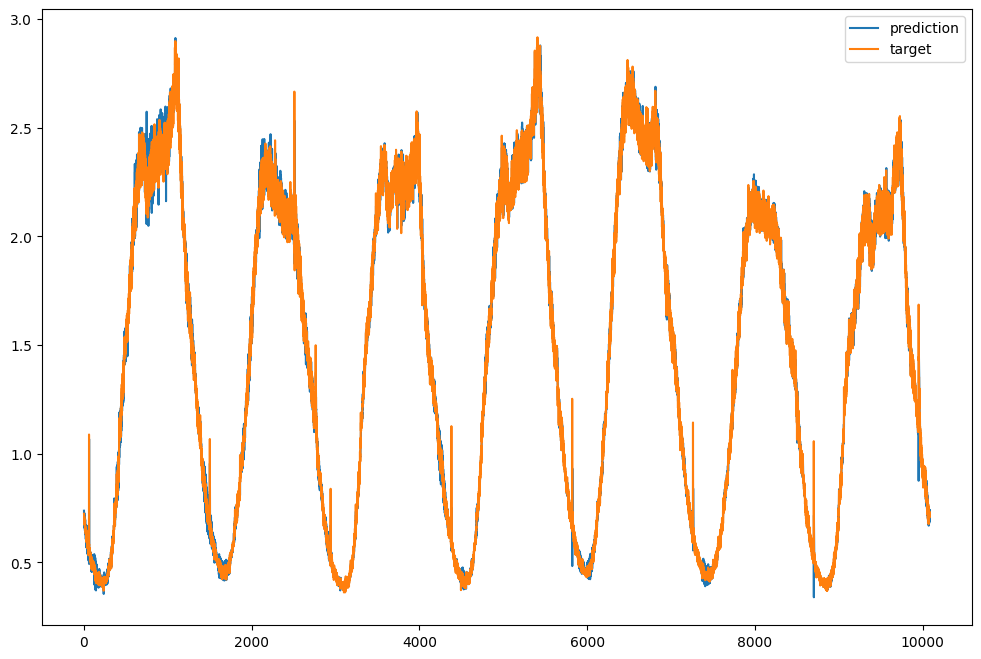

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.73808658, 0.7283439 , 0.70875746, ..., 0.74386263, 0.68876368,
       0.74100983])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.72416 ],
       [0.718512],
       [0.69116 ],
       ...,
       [0.736008],
       [0.705272],
       [0.728872]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 2.8091376647353172 %
RMSE 0.0510689839720726
MAPE 2.800575830042362 %


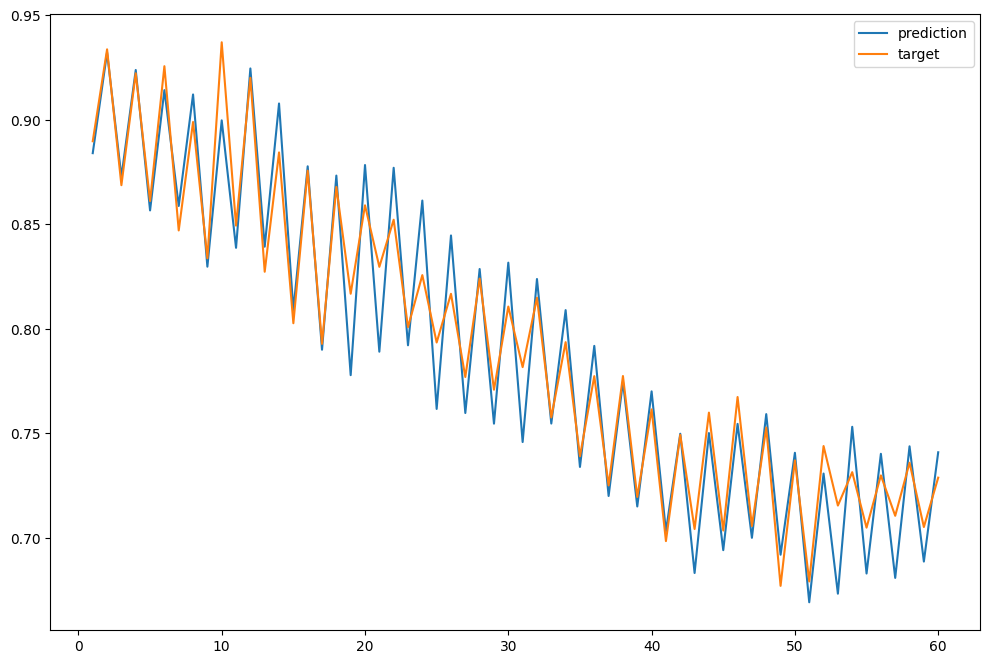

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

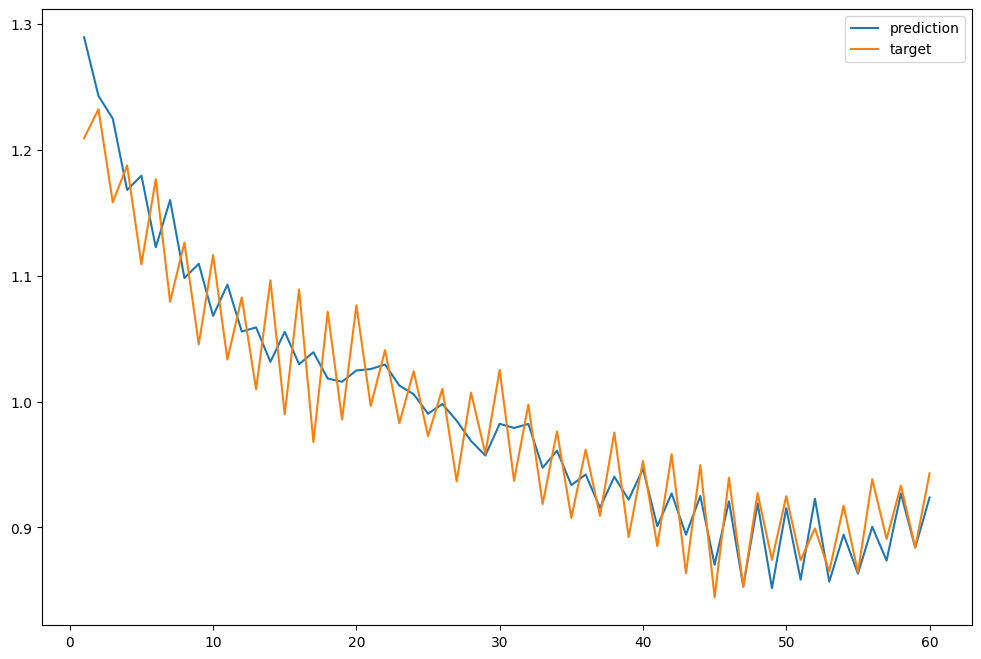

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [27]:
len(time_list)

10080

In [28]:
np.mean(time_list) 

0.43796512848801084